In [1]:
import os

import numpy as np
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob



# from dataloader import CityScapesDataset
# from transformations import *

In [2]:
from torch.utils.data import Dataset
from labels import labels

In [26]:
class CityScapesDataset(Dataset):
    def __init__(self, root, transform=None, split='train', label_map='id', crop=True):
        """
        
        """
        self.root = root
        self.transform = transform
        self.label_map = label_map
        self.crop = crop

        self.left_paths = glob(os.path.join(root, 'leftImg8bit', split, '**/*.png'),recursive=True)
        self.mask_paths = glob(os.path.join(root, 'gtFine', split, '**/*gtFine_labelIds.png'),recursive=True)
        self.depth_paths = glob(os.path.join(root, 'crestereo_depth2', split, '**/*.npy'),recursive=True)
        # self.disparity_paths = glob(os.path.join(root, 'disparity', split, '**/*.png'), recursive=True)
        
        # Print the first few elements to verify they are populated
        # print("RGB paths:", self.left_paths[:1])
        # print("Mask paths:", self.mask_paths[:1])
        # print("Disparity paths:", self.disparity_paths[:1])

        sorted(self.left_paths)
        sorted(self.mask_paths)
        sorted(self.depth_paths)
        # sorted(self.disparity_paths)

        # get label mappings
        self.id_2_train = {}
        self.id_2_cat = {}
        self.train_2_id = {}
        self.id_2_name = {-1 : 'unlabeled'}
        self.trainid_2_name = {19 : 'unlabeled'} # {255 : 'unlabeled', -1 : 'unlabeled'}

        for lbl in labels:
            self.id_2_train.update({lbl.id : lbl.trainId})
            self.id_2_cat.update({lbl.id : lbl.categoryId})
            if lbl.trainId != 19: # (lbl.trainId > 0) and (lbl.trainId != 255):
                self.trainid_2_name.update({lbl.trainId : lbl.name})
                self.train_2_id.update({lbl.trainId : lbl.id})
            if lbl.id > 0:
                self.id_2_name.update({lbl.id : lbl.name})


    def __getitem__(self, idx):
        left = cv2.cvtColor(cv2.imread(self.left_paths[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_UNCHANGED).astype(np.uint8)
        depth = np.load(self.depth_paths[idx], allow_pickle=True) # data is type float16
        # depth = cv2.imread(self.depth_paths[idx])
        # disparity = cv2.imread(self.disparity_paths[idx], cv2.IMREAD_UNCHANGED)
        
        # Check if files exist
        if not os.path.exists(self.left_paths[idx]):
            raise FileNotFoundError(f"RGB file not found: {self.left_paths[idx]}")
        if not os.path.exists(self.mask_paths[idx]):
            raise FileNotFoundError(f"Mask file not found: {self.mask_paths[idx]}")
        # if not os.path.exists(self.disparity_paths[idx]):
        #     raise FileNotFoundError(f"Disparity file not found: {self.disparity_paths[idx]}")
        if not os.path.exists(self.depth_paths[idx]):
            raise FileNotFoundError(f"depth file not found: {self.depth_paths[idx]}")

        if self.crop:
            left = left[:800, :, :]
            mask = mask[:800, :]
            depth = depth[:800, :]

        # get label id
        if self.label_map == 'id':
            mask[mask==-1] == 0
        elif self.label_map == 'trainId':
            for _id, train_id in self.id_2_train.items():
                mask[mask==_id] = train_id
        elif self.label_map == 'categoryId':
            for _id, train_id in self.id_2_cat.items():
                mask[mask==_id] = train_id

        sample = {'left' : left, 'mask' : mask, 'depth' : depth}

        if self.transform:
            sample = self.transform(sample)

        # ensure that no depth values are less than 0
        depth[depth < 0] = 0

        return sample
    

    def __len__(self):
        print(f"Number of RGB images: {len(self.left_paths)}")
        print(f"Number of Mask images: {len(self.mask_paths)}")
        print(f"Number of depth images: {len(self.depth_paths)}")
        # print(f"Number of Disparity images: {len(self.disparity_paths)}")
        return len(self.left_paths)

In [27]:
curr_dir=os.getcwd()
root= os.path.join(curr_dir,"cityscapes_dataset")
root

'/home/rmajumd/2024/ML_in_image_synthesis/Cityscapes/Cityscapes/cityscapes_dataset'

In [28]:
BATCH_SIZE = 64

train_dataset = CityScapesDataset(root, transform=None, split='train', label_map='trainId') # 'trainId')
print("Dataset length:", len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False) # set Shuffle to True

Number of RGB images: 2975
Number of Mask images: 2975
Number of depth images: 2975
Dataset length: 2975


In [29]:
# from glob import glob
# print(glob(os.path.join(root, 'leftImg8bit', 'train', '**/*.png'), recursive=True))


In [30]:
sample = next(iter(train_loader))

Number of RGB images: 2975
Number of Mask images: 2975
Number of depth images: 2975


In [31]:
_, _, depth = sample['left'], sample['mask'], sample['depth']

In [32]:
depth = depth.numpy()
depth.shape

(64, 800, 2048)

In [33]:
depth.min(), depth.max(), depth.mean(), depth.astype(np.float32).std()

(0.0, 1594354.8, 38.868683, 214.79007)

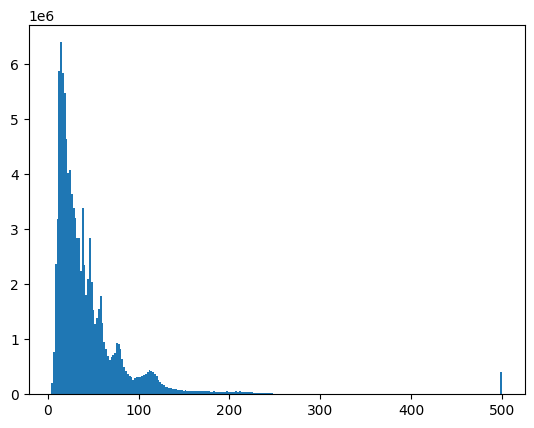

In [64]:
plt.hist(depth.flatten(), bins=250);

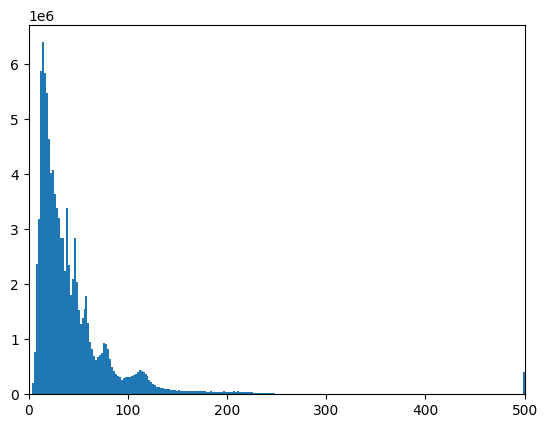

In [66]:
plt.hist(depth.flatten(), bins=250);
plt.xlim(0, 500);

In [68]:
depth = np.clip(depth, 0, 250)

depth.min(), depth.max(), depth.mean(), depth.astype(np.float32).std()

(3.7555501, 250.0, 44.332836, 41.301517)

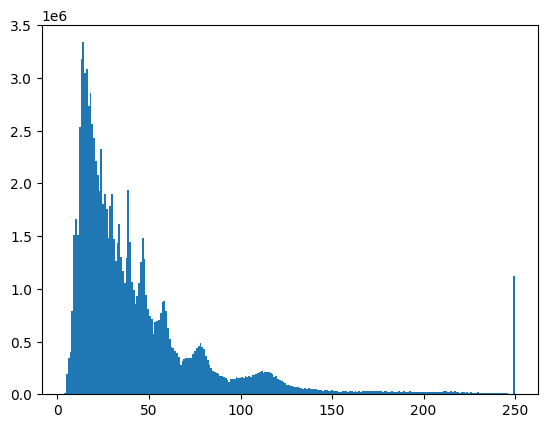

In [69]:
plt.hist(depth.flatten(), bins=250);

In [70]:
np.log(250)

5.521460917862246

In [71]:
transformed_depth = np.log(depth.flatten())/5

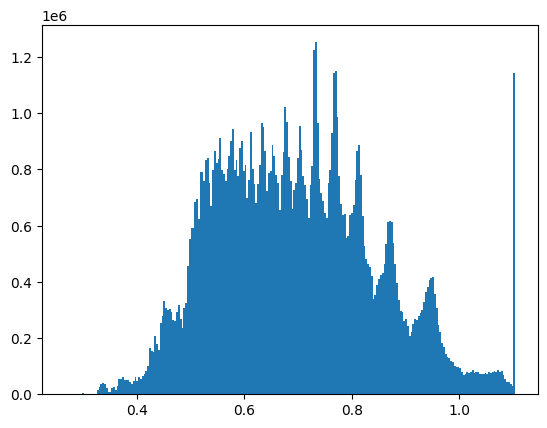

In [72]:
plt.hist(transformed_depth, bins=250);

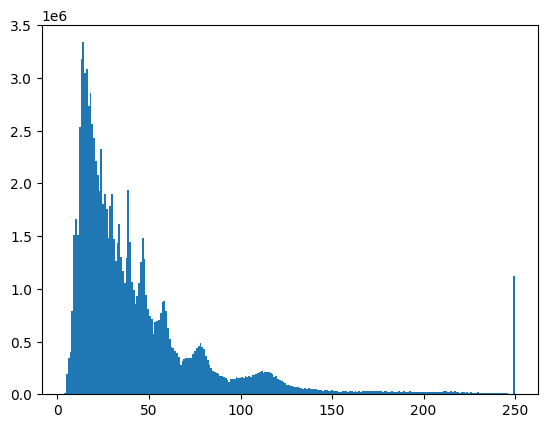

In [73]:
plt.hist(np.exp(transformed_depth*5), bins=250);